In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Input, BatchNormalization
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
train_df=pd.read_csv('data\mitbih_train.csv',header=None)
test_df=pd.read_csv('data\mitbih_test.csv',header=None)

In [3]:
print('Train Data Shape:', train_df.shape, '\nTest Data Shape:', test_df.shape)

Train Data Shape: (87554, 188) 
Test Data Shape: (21892, 188)


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87554 entries, 0 to 87553
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 125.6 MB


In [5]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21892 entries, 0 to 21891
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 31.4 MB


In [6]:
categories_train = train_df[187].value_counts()

In [7]:
print(categories_train)

187
0.0    72471
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: count, dtype: int64


In [8]:
categories_test = test_df[187].value_counts()
print(categories_test)

187
0.0    18118
4.0     1608
2.0     1448
1.0      556
3.0      162
Name: count, dtype: int64


In [9]:
#change the label type from float to integer
train_df[187] = train_df[187].astype(int)
test_df[187] = test_df[187].astype(int)

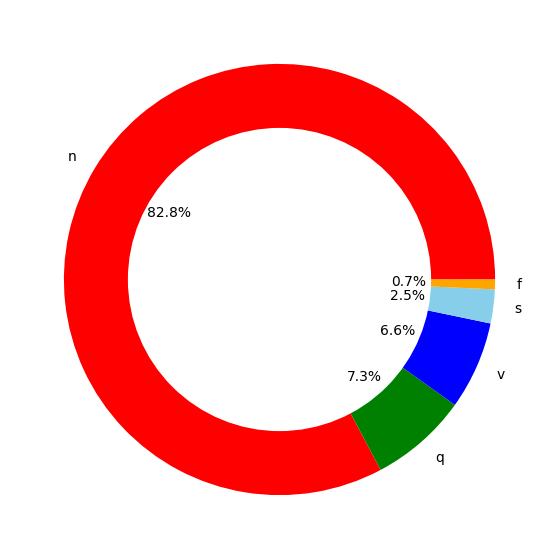

In [10]:
plt.figure(figsize=(10,7))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(categories_train, labels=['n','q','v','s','f'], colors=['red','green','blue','skyblue','orange'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

#### Make it Binary

In [11]:
train_df[187] = [1 if i > 0 else i for i in train_df[187]]
test_df[187] = [1 if i > 0 else i for i in test_df[187]]

In [12]:
categories_1 = train_df[187].value_counts()

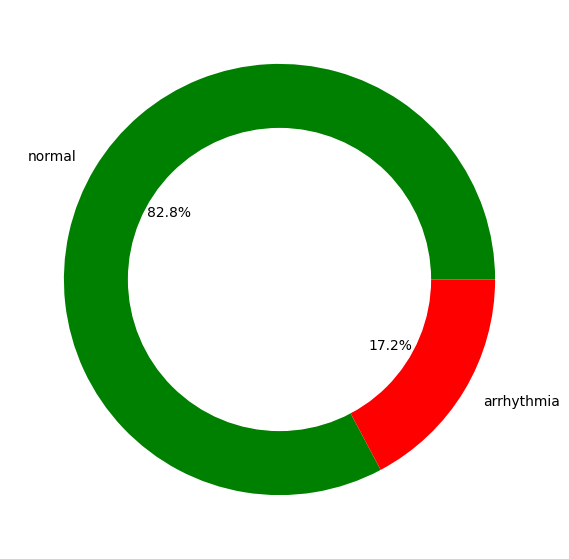

In [13]:
plt.figure(figsize=(10,7))
my_circle_1 =plt.Circle( (0,0), 0.7, color='white')
plt.pie(categories_1, labels=['normal','arrhythmia'], colors=['green','red'], autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle_1)
plt.show()

#### Adding Noise

In [14]:
def add_gaussian_noise(signal):
    noise = np.random.normal(0, 0.5, 186)
    return np.array(signal + noise)

In [15]:
from sklearn.utils.class_weight import compute_class_weight

def preprocess_data(train_df, test_df):
    y_train = train_df[187]
    y_test = test_df[187]

    X_train = train_df.iloc[:, :186].values
    X_test = test_df.iloc[:, :186].values

    for i in range(len(X_train)):
        X_train[i, :186] = add_gaussian_noise(X_train[i, :186])

    X_train = X_train.reshape(len(X_train), X_train.shape[1], 1)
    X_test = X_test.reshape(len(X_test), X_test.shape[1], 1)

    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train.ravel()), y=y_train.ravel())
    class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

    return X_train, y_train, X_test, y_test, class_weights_dict

In [16]:
# Preprocess data
X_train, y_train, X_test, y_test, class_weights_dict = preprocess_data(train_df, test_df)

#### CNN Model

In [19]:
def build_model(input_shape):
    inputs_cnn = Input(shape=input_shape, name='inputs_cnn')
    conv1_1 = Conv1D(64, kernel_size=6, activation='relu')(inputs_cnn)
    conv1_1 = BatchNormalization()(conv1_1)
    pool1 = MaxPooling1D(pool_size=3, strides=2, padding="same")(conv1_1)
    conv2_1 = Conv1D(64, kernel_size=3, activation='relu')(pool1)
    conv2_1 = BatchNormalization()(conv2_1)
    pool2 = MaxPooling1D(pool_size=2, strides=2, padding="same")(conv2_1)
    conv3_1 = Conv1D(64, kernel_size=3, activation='relu')(pool2)
    conv3_1 = BatchNormalization()(conv3_1)
    pool3 = MaxPooling1D(pool_size=2, strides=2, padding="same")(conv3_1)
    flatten = Flatten()(pool3)
    dense_end1 = Dense(64, activation='relu')(flatten)
    dense_end2 = Dense(32, activation='relu')(dense_end1)
    main_output = Dense(1, activation='sigmoid', name='main_output')(dense_end2)
    
    model = Model(inputs=inputs_cnn, outputs=main_output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [17]:
def evaluate_model(model, history, X_test, y_test):
    scores = model.evaluate(X_test, y_test, verbose=0)
    print("Test Loss:", scores[0])
    print("Test Accuracy:", scores[1])
    
    y_pred = model.predict(X_test)
    y_pred_classes = np.round(y_pred)
    print("Classification Report:")
    print(classification_report(y_test, y_pred_classes))

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.show()

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

In [21]:
import keras
from keras.layers import Dense, Convolution1D, MaxPool1D, Flatten, Dropout
from keras.layers import Input
from keras.models import Model
from keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint

def train_model(X_train, y_train, X_test, y_test, class_weights):
    input_shape = (X_train.shape[1], 1)
    model = build_model(input_shape)
    
    callbacks = [EarlyStopping(monitor='val_loss', patience=8),
                 ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

    history = model.fit(X_train, y_train, epochs=20, batch_size=64, callbacks=callbacks, 
                        validation_data=(X_test, y_test), class_weight=class_weights, verbose=1)
    
    model.load_weights('best_model.h5')
    
    return model, history

Epoch 1/20
1369/1369 [==============================] - 134s 97ms/step - loss: 0.4994 - accuracy: 0.7768 - val_loss: 0.3535 - val_accuracy: 0.8567
Epoch 2/20
1369/1369 [==============================] - 143s 104ms/step - loss: 0.4437 - accuracy: 0.8203 - val_loss: 0.3562 - val_accuracy: 0.8710
Epoch 3/20
1369/1369 [==============================] - 139s 102ms/step - loss: 0.4211 - accuracy: 0.8296 - val_loss: 0.3320 - val_accuracy: 0.8819
Epoch 4/20
1369/1369 [==============================] - 132s 96ms/step - loss: 0.3980 - accuracy: 0.8382 - val_loss: 0.4076 - val_accuracy: 0.8284
Epoch 5/20
1369/1369 [==============================] - 117s 85ms/step - loss: 0.3705 - accuracy: 0.8476 - val_loss: 0.4032 - val_accuracy: 0.8423
Epoch 6/20
1369/1369 [==============================] - 132s 96ms/step - loss: 0.3378 - accuracy: 0.8615 - val_loss: 0.3658 - val_accuracy: 0.8493
Epoch 7/20
1369/1369 [==============================] - 120s 88ms/step - loss: 0.3016 - accuracy: 0.8743 - val_loss:

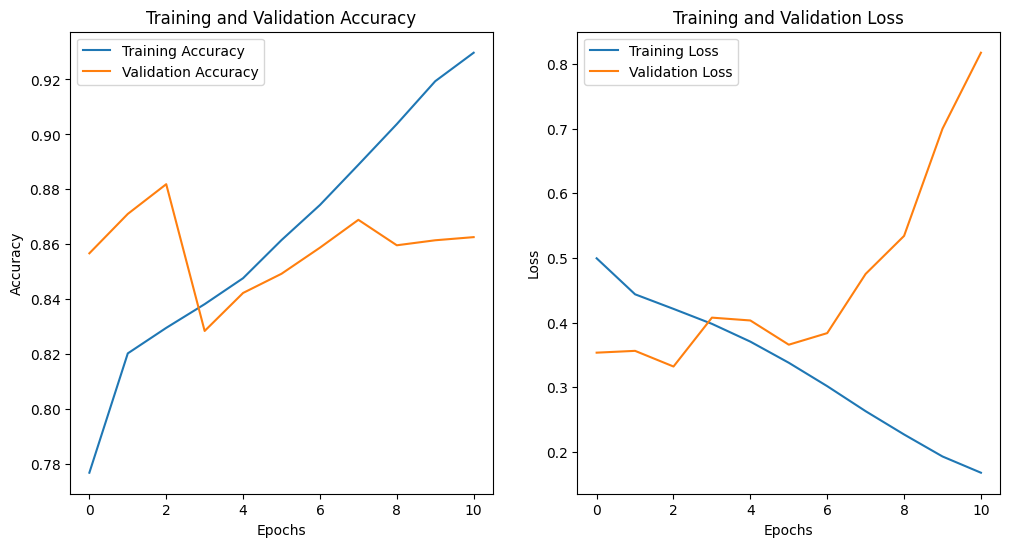

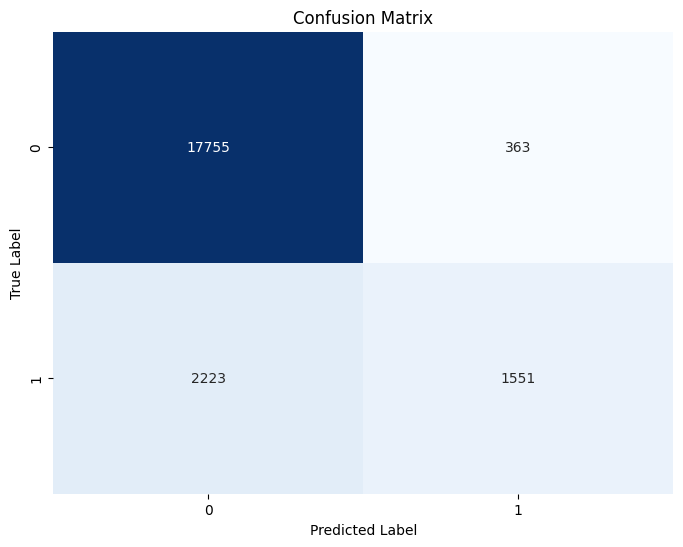

In [24]:
# Assuming train_df and test_df are already loaded
X_train, y_train, X_test, y_test, class_weights = preprocess_data(train_df, test_df)
model, history = train_model(X_train, y_train, X_test, y_test, class_weights)
evaluate_model(model, history, X_test, y_test)

In [18]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

# SVM (LinearSVC) Pipeline
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LinearSVC(class_weight='balanced'))
])

# Train and evaluate SVM model
svm_pipeline.fit(X_train.squeeze(), y_train)
svm_accuracy = svm_pipeline.score(X_test.squeeze(), y_test)
print("SVM Accuracy:", svm_accuracy)


SVM Accuracy: 0.8544673853462452


In [19]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

# Random Forest Pipeline
rf_pipeline = Pipeline([
    ('clf', RandomForestClassifier(class_weight='balanced'))
])

# Train and evaluate Random Forest model
rf_pipeline.fit(X_train.squeeze(), y_train)
rf_accuracy = rf_pipeline.score(X_test.squeeze(), y_test)
print("Random Forest Accuracy:", rf_accuracy)


Random Forest Accuracy: 0.869221633473415


In [20]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Logistic Regression Pipeline
logreg_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(class_weight='balanced'))
])

# Train and evaluate Logistic Regression model
logreg_pipeline.fit(X_train.squeeze(), y_train)
logreg_accuracy = logreg_pipeline.score(X_test.squeeze(), y_test)
print("Logistic Regression Accuracy:", logreg_accuracy)


Logistic Regression Accuracy: 0.8103873561118217


SVM Evaluation:
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.97      0.91     18118
           1       0.63      0.23      0.34      3774

    accuracy                           0.84     21892
   macro avg       0.74      0.60      0.62     21892
weighted avg       0.82      0.84      0.81     21892



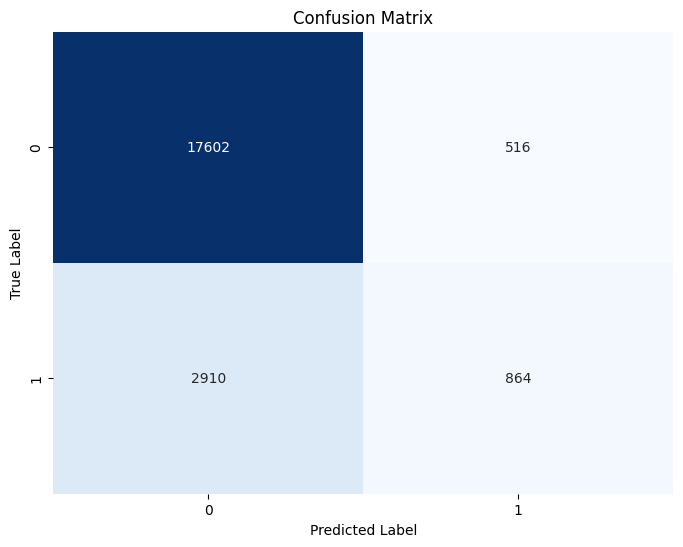

Random Forest Evaluation:
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.94      0.92     18118
           1       0.64      0.54      0.59      3774

    accuracy                           0.87     21892
   macro avg       0.78      0.74      0.76     21892
weighted avg       0.86      0.87      0.86     21892



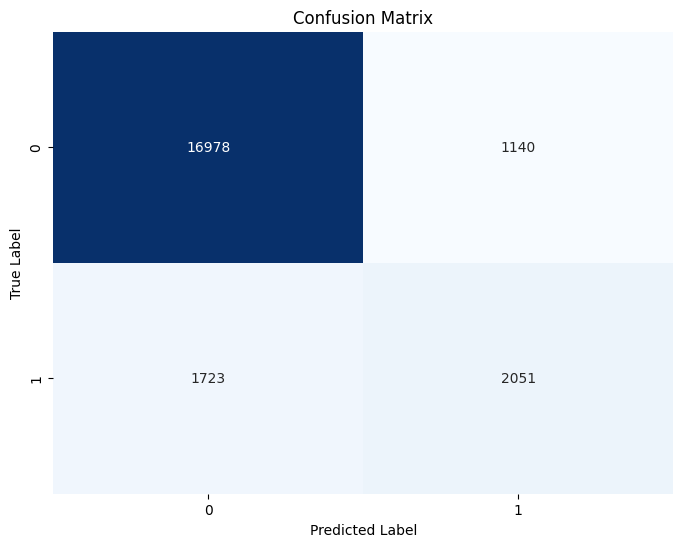

Logistic Regression Evaluation:
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.94      0.92     18118
           1       0.64      0.55      0.60      3774

    accuracy                           0.87     21892
   macro avg       0.78      0.75      0.76     21892
weighted avg       0.86      0.87      0.87     21892



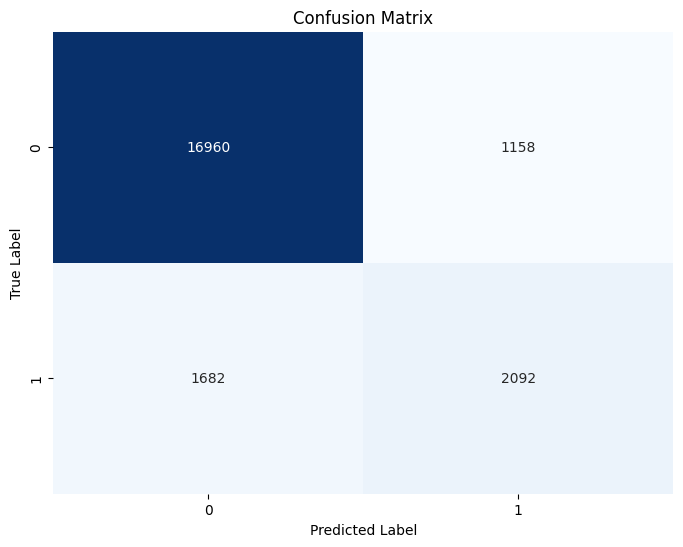

In [21]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

def evaluate_model(model, X_test, y_test):
    if hasattr(model, "decision_function"):
        # SVM
        y_pred = model.decision_function(X_test)
    else:
        # Random Forest or Logistic Regression
        y_pred = model.predict_proba(X_test)[:, 1]

    # Binarize predictions
    y_pred_classes = (y_pred > 0.5).astype(int)

    # Print classification report
    print("Classification Report:")
    print(classification_report(y_test, y_pred_classes))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

# Evaluate SVM model
print("SVM Evaluation:")
evaluate_model(svm_pipeline, X_test.squeeze(), y_test)

# Evaluate Random Forest model
print("Random Forest Evaluation:")
evaluate_model(rf_pipeline, X_test.squeeze(), y_test)

# Evaluate Logistic Regression model
print("Logistic Regression Evaluation:")
evaluate_model(logreg_pipeline, X_test.squeeze(), y_test)
